In [1]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

ROOT = Path.cwd()
DATA_DIR = ROOT / "data"

BIG_CSV = DATA_DIR / "laion_aesthetic_subset_metadata_big_REBUILT.csv"
assert BIG_CSV.exists(), f"CSV introuvable: {BIG_CSV}"

df = pd.read_csv(BIG_CSV)
print("✅ Chargé:", df.shape)
display(df.head())


✅ Chargé: (200993, 8)


,image_path,caption,width,height,similarity,punsafe,pwatermark,aesthetic_score
0,src/data/data/laion_aesthetic_subset_big\00000...,Photo pour Japanese pagoda and old house in Ky...,450.0,297.0,0.345947,0.000541,0.034099,6.526204
1,src/data/data/laion_aesthetic_subset_big\00000...,Soaring by Peter Eades,675.0,900.0,0.310405,0.000006,0.076448,6.636003
2,src/data/data/laion_aesthetic_subset_big\00000...,far cry 4 concept art is the reason why it 39 ...,1600.0,754.0,0.316400,0.000043,0.496503,6.690522
3,src/data/data/laion_aesthetic_subset_big\00000...,San Pedro: One Of Mother Nature's Most Powerfu...,467.0,369.0,0.308873,0.000612,0.102705,6.749783
4,src/data/data/laion_aesthetic_subset_big\00000...,"YZV200025S © Stocktrek Images, Inc. 360 panora...",650.0,308.0,0.332100,0.000013,0.057178,6.529371


In [2]:
print("Colonnes:", list(df.columns))

# Colonnes attendues (selon tes anciens csv)
for c in ["image_path", "caption", "width", "height", "punsafe", "pwatermark", "aesthetic_score", "similarity"]:
    print(f"{c:15s} ->", "OK" if c in df.columns else "absent")

display(df.isna().mean().sort_values(ascending=False).head(20) * 100)


Colonnes: ['image_path', 'caption', 'width', 'height', 'similarity', 'punsafe', 'pwatermark', 'aesthetic_score']
image_path      -> OK
caption         -> OK
width           -> OK
height          -> OK
punsafe         -> OK
pwatermark      -> OK
aesthetic_score -> OK
similarity      -> OK


pwatermark         1.040832
width              0.282099
similarity         0.276129
height             0.179608
image_path         0.000000
caption            0.000000
punsafe            0.000000
aesthetic_score    0.000000
dtype: float64

In [3]:
THRESH = {
    "min_width": 224,
    "min_height": 224,
    "max_punsafe": 0.3,      # plus petit = plus strict
    "max_pwatermark": 0.5,   # plus petit = plus strict
    "min_caption_words": 3,
    "max_caption_words": 50,
    "min_aesthetic": 6.5     # ton dataset est déjà >=6.5 mais on le garde
}

THRESH


{'min_width': 224,
 'min_height': 224,
 'max_punsafe': 0.3,
 'max_pwatermark': 0.5,
 'min_caption_words': 3,
 'max_caption_words': 50,
 'min_aesthetic': 6.5}

In [4]:
df2 = df.copy()

# caption length
df2["caption_len_words"] = df2["caption"].fillna("").astype(str).apply(lambda x: len(x.split()))

# présence fichiers
def exists_local(p):
    if not isinstance(p, str) or len(p) == 0:
        return False
    pp = Path(p)
    if pp.is_absolute():
        return pp.exists()
    return (ROOT / pp).exists()

df2["exists"] = df2["image_path"].apply(exists_local)

mask_exists = df2["exists"]

mask_res = True
if "width" in df2.columns and "height" in df2.columns:
    mask_res = (df2["width"] >= THRESH["min_width"]) & (df2["height"] >= THRESH["min_height"])

mask_nsfw = True
if "punsafe" in df2.columns:
    mask_nsfw = df2["punsafe"].fillna(1.0) <= THRESH["max_punsafe"]

mask_wm = True
if "pwatermark" in df2.columns:
    mask_wm = df2["pwatermark"].fillna(1.0) <= THRESH["max_pwatermark"]

mask_caption = (df2["caption_len_words"] >= THRESH["min_caption_words"]) & (df2["caption_len_words"] <= THRESH["max_caption_words"])

mask_aesth = True
if "aesthetic_score" in df2.columns:
    mask_aesth = df2["aesthetic_score"].fillna(-1.0) >= THRESH["min_aesthetic"]

df2["keep_quality"] = mask_exists & mask_res & mask_nsfw & mask_wm & mask_caption & mask_aesth

print("✅ Kept:", df2["keep_quality"].sum(), "/", len(df2), f"({df2['keep_quality'].mean()*100:.2f}%)")

# Stats de rejet par critère (indépendant)
reject_stats = {
    "missing_file": (~mask_exists).mean()*100,
    "low_resolution": (~mask_res).mean()*100 if isinstance(mask_res, pd.Series) else 0.0,
    "nsfw_high": (~mask_nsfw).mean()*100 if isinstance(mask_nsfw, pd.Series) else 0.0,
    "watermark_high": (~mask_wm).mean()*100 if isinstance(mask_wm, pd.Series) else 0.0,
    "caption_bad_len": (~mask_caption).mean()*100,
    "aesthetic_low": (~mask_aesth).mean()*100 if isinstance(mask_aesth, pd.Series) else 0.0,
}
reject_stats


✅ Kept: 153216 / 200993 (76.23%)


{'missing_file': np.float64(0.0),
 'low_resolution': np.float64(4.193180857044773),
 'nsfw_high': np.float64(3.669779544561253),
 'watermark_high': np.float64(10.825750150502754),
 'caption_bad_len': np.float64(7.312692481827725),
 'aesthetic_low': np.float64(0.0)}

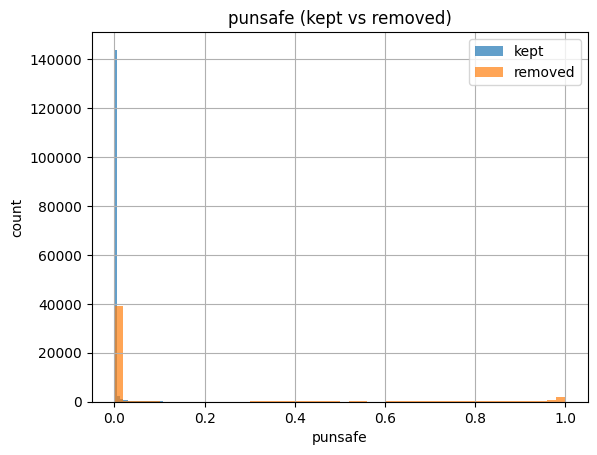

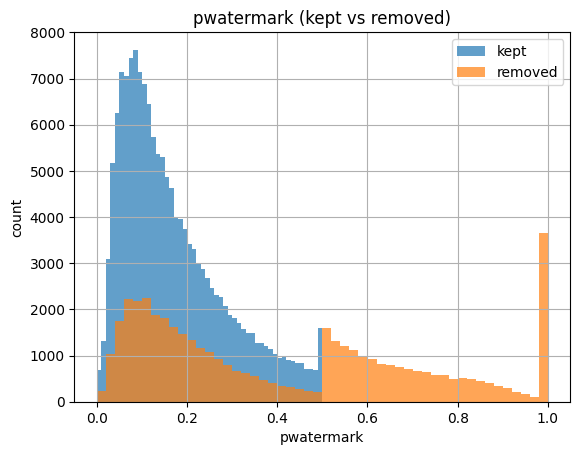

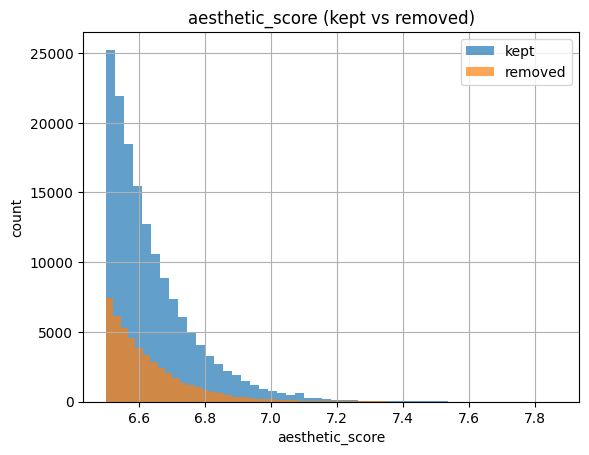

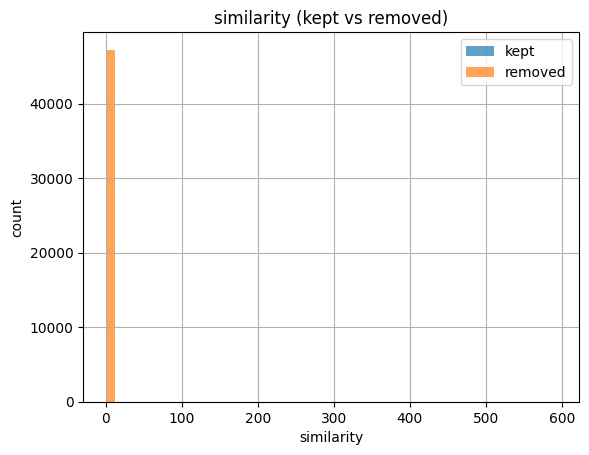

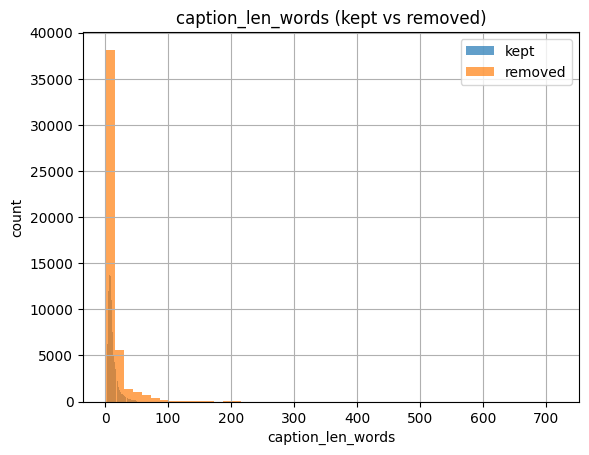

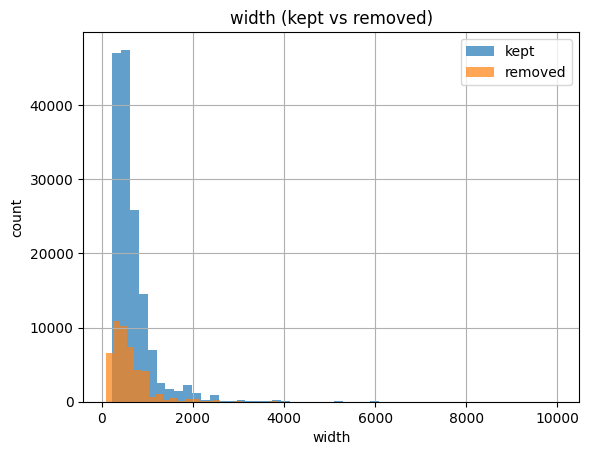

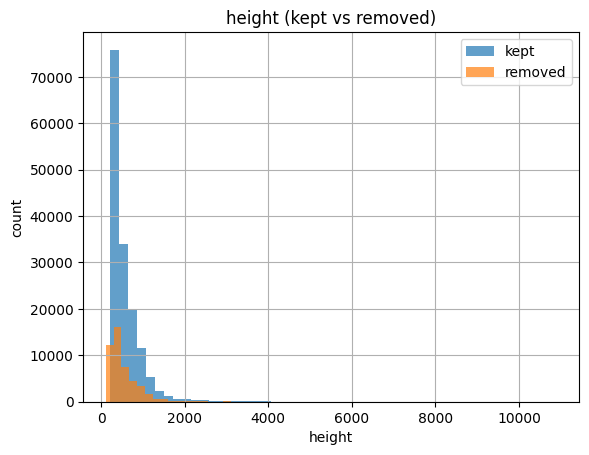

In [5]:
kept = df2[df2["keep_quality"]]
removed = df2[~df2["keep_quality"]]

def plot_hist(col):
    if col not in df2.columns:
        return
    plt.figure()
    kept[col].dropna().hist(bins=50, alpha=0.7)
    removed[col].dropna().hist(bins=50, alpha=0.7)
    plt.title(f"{col} (kept vs removed)")
    plt.xlabel(col)
    plt.ylabel("count")
    plt.legend(["kept", "removed"])
    plt.show()

for c in ["punsafe", "pwatermark", "aesthetic_score", "similarity", "caption_len_words", "width", "height"]:
    plot_hist(c)


In [6]:
OUT_CSV = DATA_DIR / "laion_big_quality_filtered.csv"
kept.to_csv(OUT_CSV, index=False)
print("✅ Saved:", OUT_CSV, "| rows:", len(kept))


✅ Saved: C:\Debiasing-and-Improving-the-Robustness-of-CLIP-like-Models\data\laion_big_quality_filtered.csv | rows: 153216
